In [3]:
#Importing useful libraries
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure, img_as_uint
import cv2
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#loading data
dataTrain = nib.load('tr_im.nii.gz')
dataTest = nib.load('val_im.nii.gz')

In [2]:
#function to show n images
def showImages(images, rows, cols):
    plt.figure(figsize = (16,16))
    for i in range (rows*cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Lung')
        plt.xticks(())
        plt.yticks(())

## The following code is an adaptation from kaggle Data Science Bowl 2017. Credits to his owner Ankasor user
https://www.kaggle.com/ankasor/improved-lung-segmentation-using-watershed?scriptVersionId=757554

In [11]:
#function to get the images into an numpy array of type int16
#our images are in the HU scale, so its not necessary convert it again!
def getImages(data):
    image = np.stack([data.get_fdata()[:,:,s] for s in range(data.shape[2])])
    image = image.astype(np.int16)
    return np.array(image, dtype=np.int16)

First 25 Train Images
######################################


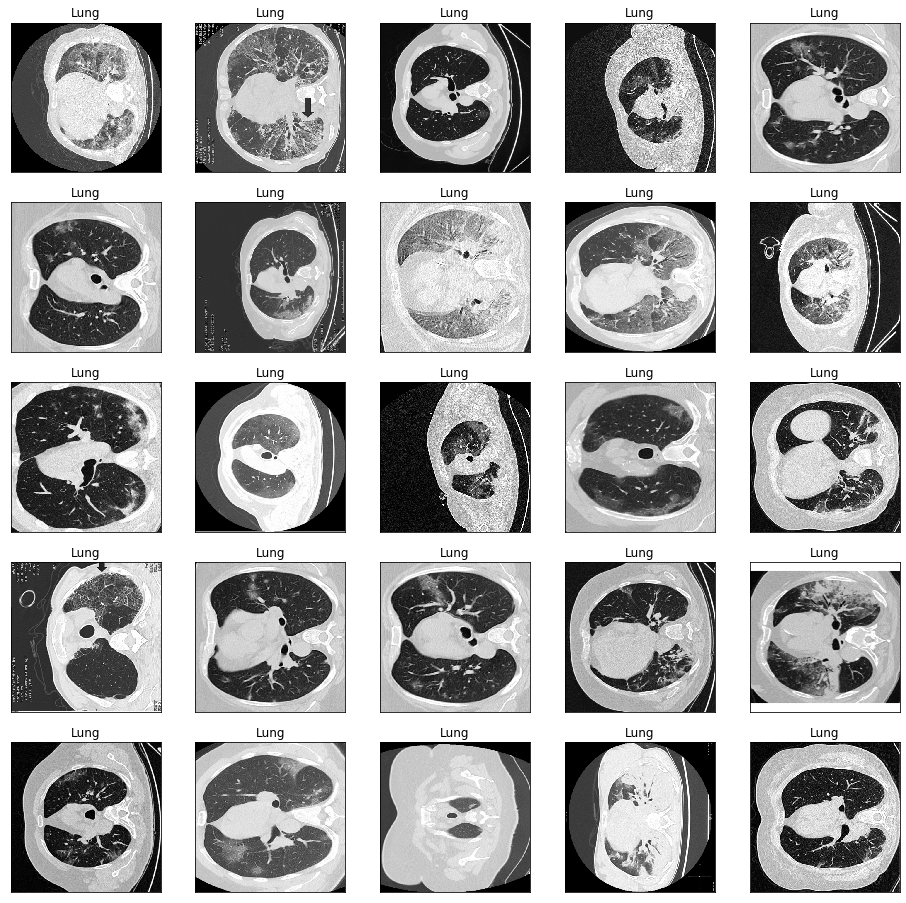

In [20]:
#getting
train = getImages(dataTrain)
test = getImages(dataTest)
showImages(train[:25],5,5)
print('First 25 Train Images')
print('######################################')

All Test Images
######################################


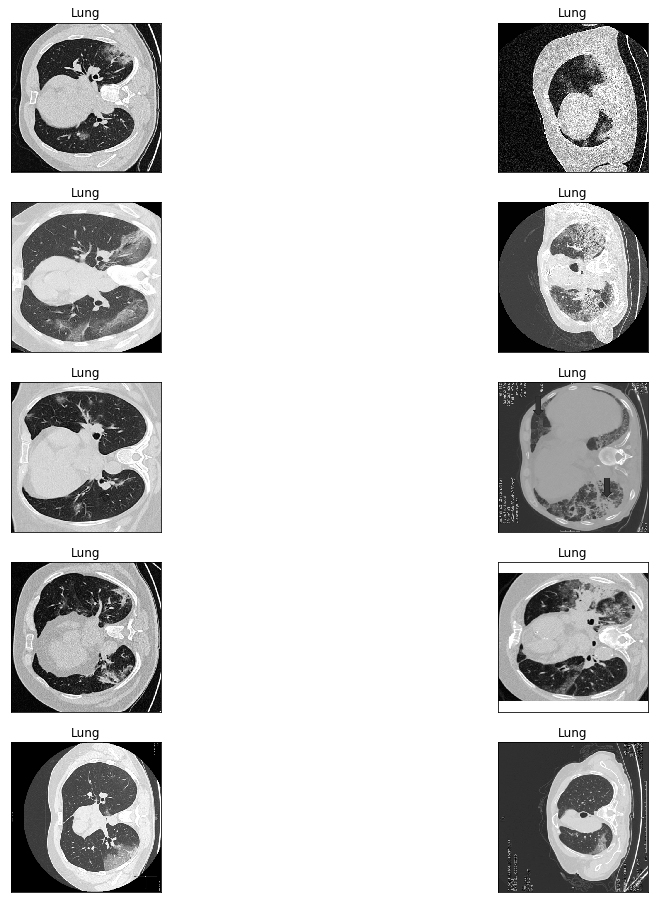

In [22]:
showImages(test[:10],5,2)
print('All Test Images')
print('######################################')

In [68]:
#function to get the lungs and its surroundings (white part wich corresponds to bones or body)
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -250
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

Internal Marker


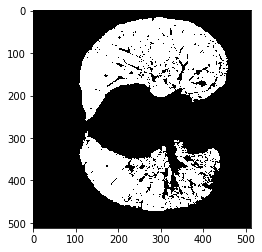

External Marker


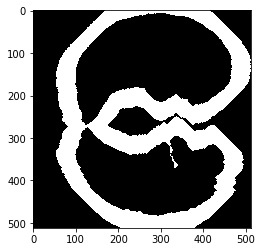

Watershed Marker


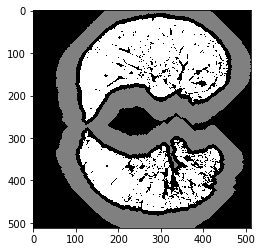

In [69]:
trainLung, trainExternal, trainWatershed = generate_markers(train[1])
print ("Internal Marker")
plt.imshow(trainLung, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(trainExternal, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(trainWatershed, cmap='gray')
plt.show()

In [70]:
#function to do the previous step iteratively
def getAllMarkers(images):
    lung = []
    external = []
    watershed = []
    for i in range(images.shape[0]):
        auxLung, auxExternal, auxWatershed = generate_markers(images[i])
        lung.append(auxLung)
        external.append(auxExternal)
        watershed.append(auxWatershed)
    return lung, external, watershed

First 16 Watershed Train Images
######################################


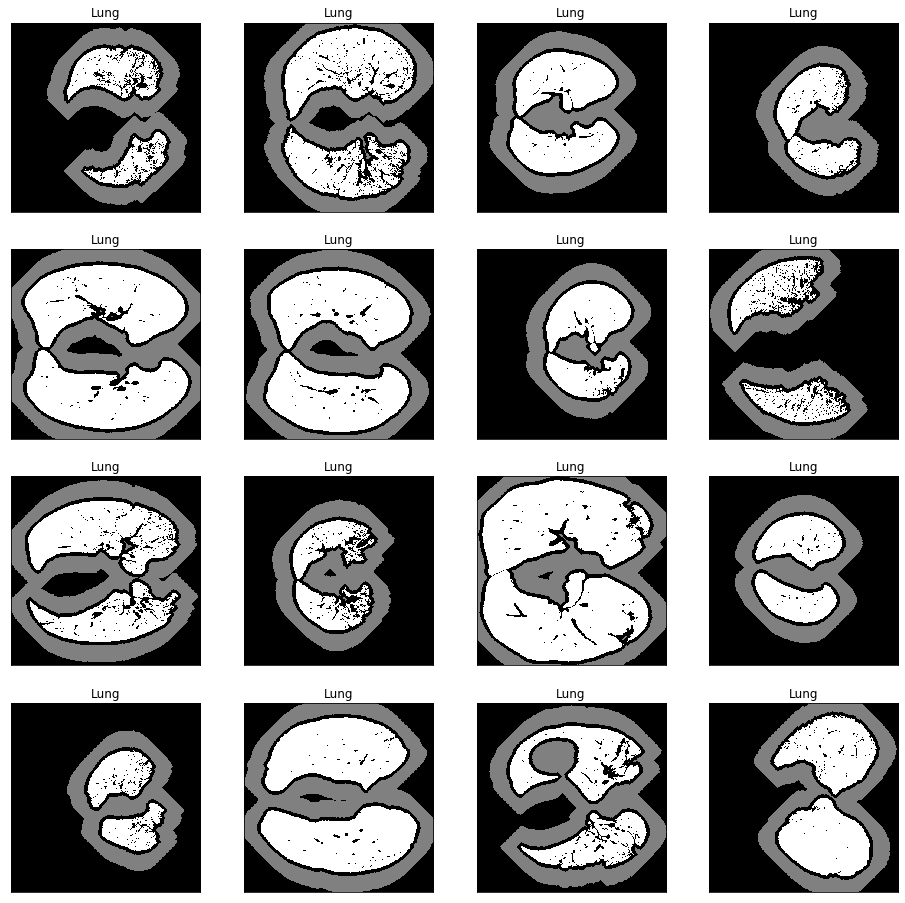

In [71]:
trainLung, trainExternal, trainWatershed = getAllMarkers(train)
testLung, testExternal, testWatershed = getAllMarkers(test)
showImages(trainWatershed[:16],4,4)
print('First 16 Watershed Train Images')
print('######################################')

All Watershed Test Images
######################################


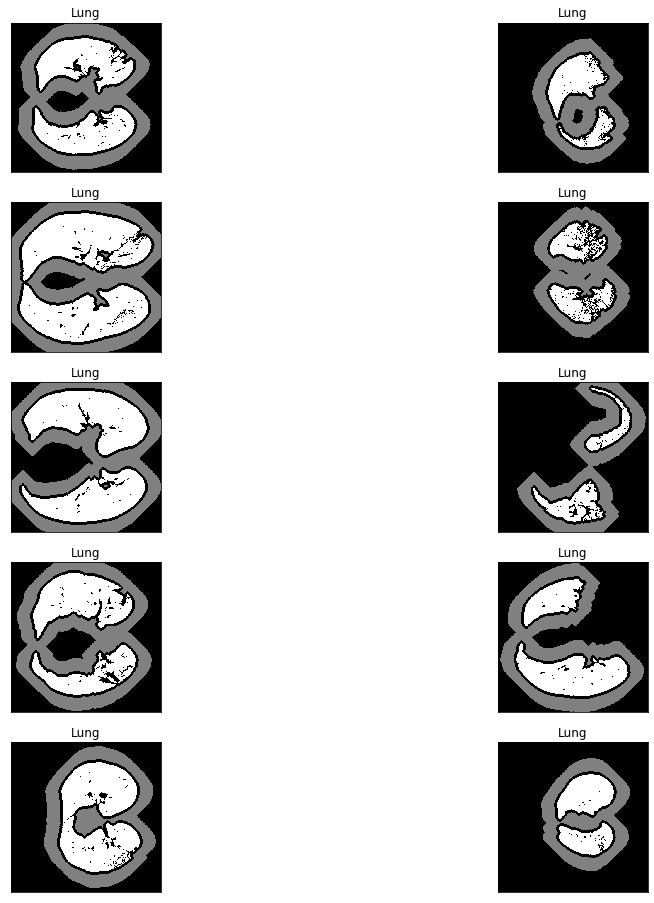

In [72]:
showImages(testWatershed[:10],5,2)
print('All Watershed Test Images')
print('######################################')

In [73]:
#function to segment the lungs
def seperate_lungs(image):
    #Creation of the markers as before:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

Sobel Gradient


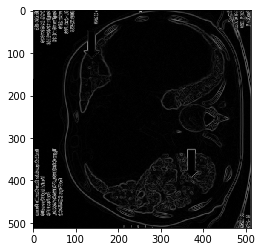

Watershed Image


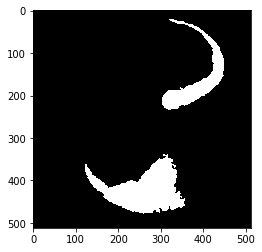

Outline after reinclusion


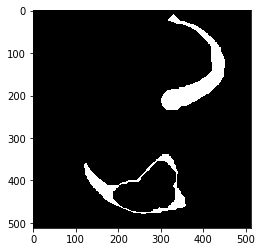

Lungfilter after closing


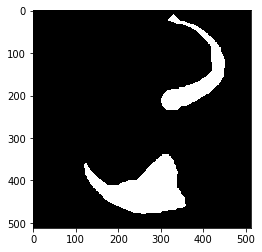

Segmented Lung


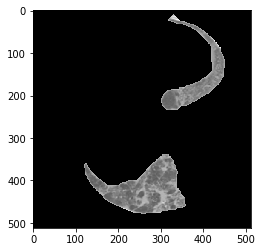

In [74]:
testSegmented, testLungfilter, testOutline, testWatershed, testSobelGradient, testLung, testExternal, testMarkerWatershed = seperate_lungs(test[5])

print ("Sobel Gradient")
plt.imshow(testSobelGradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(testWatershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(testOutline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(testLungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(testSegmented, cmap='gray')
plt.show()

In [75]:
#function to do the previous step iteratively
def segmentLungs(images):
    sobel = []
    segmentedLungs = []
    masks = []
    for i in range(images.shape[0]):
        segmented,lungfilter,Outline,watershed,sobelGradient,lung,external,MarkerWatershed = seperate_lungs(images[i])
        sobel.append(sobelGradient)
        segmentedLungs.append(segmented)
        masks.append(lungfilter)
    return sobel, segmentedLungs, masks

In [76]:
trainSobel, trainSegmentedLungs, trainMasks = segmentLungs(train)
testSobel, testSegmentedLungs, testMask = segmentLungs(test)

First 25 Segmented Lungs from Train Images
######################################


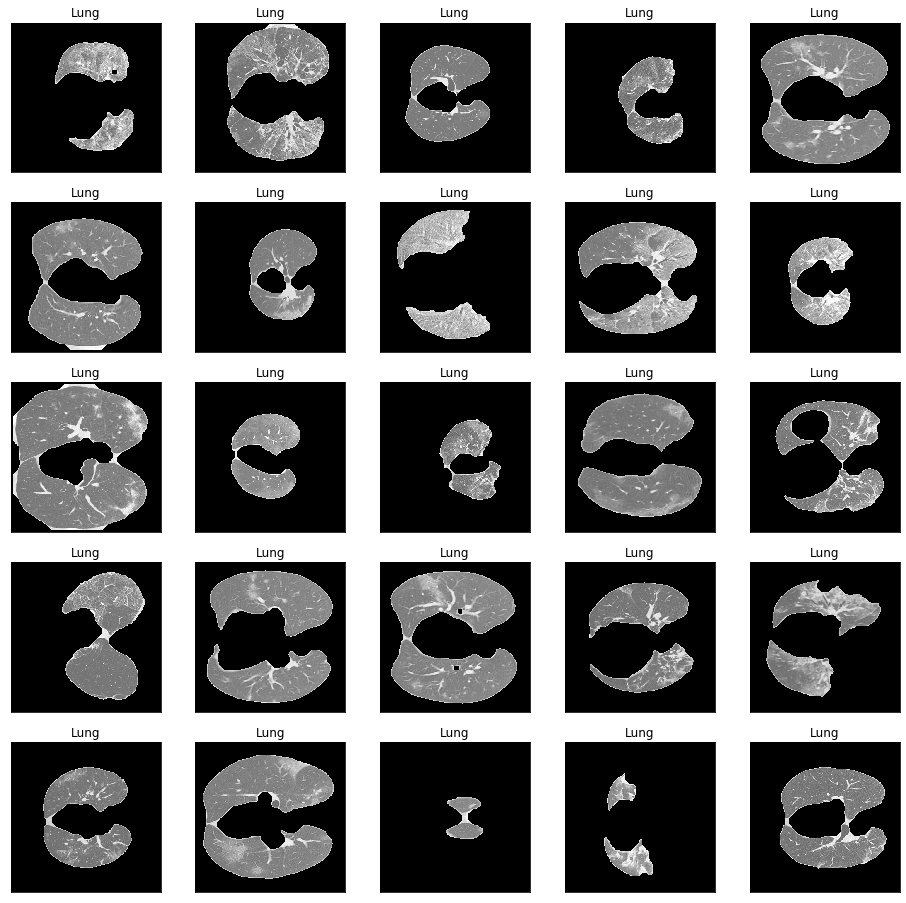

In [77]:
showImages(trainSegmentedLungs[:25],5,5)
print('First 25 Segmented Lungs from Train Images')
print('######################################')

First 25 Sobel Gradient from Train Images
######################################


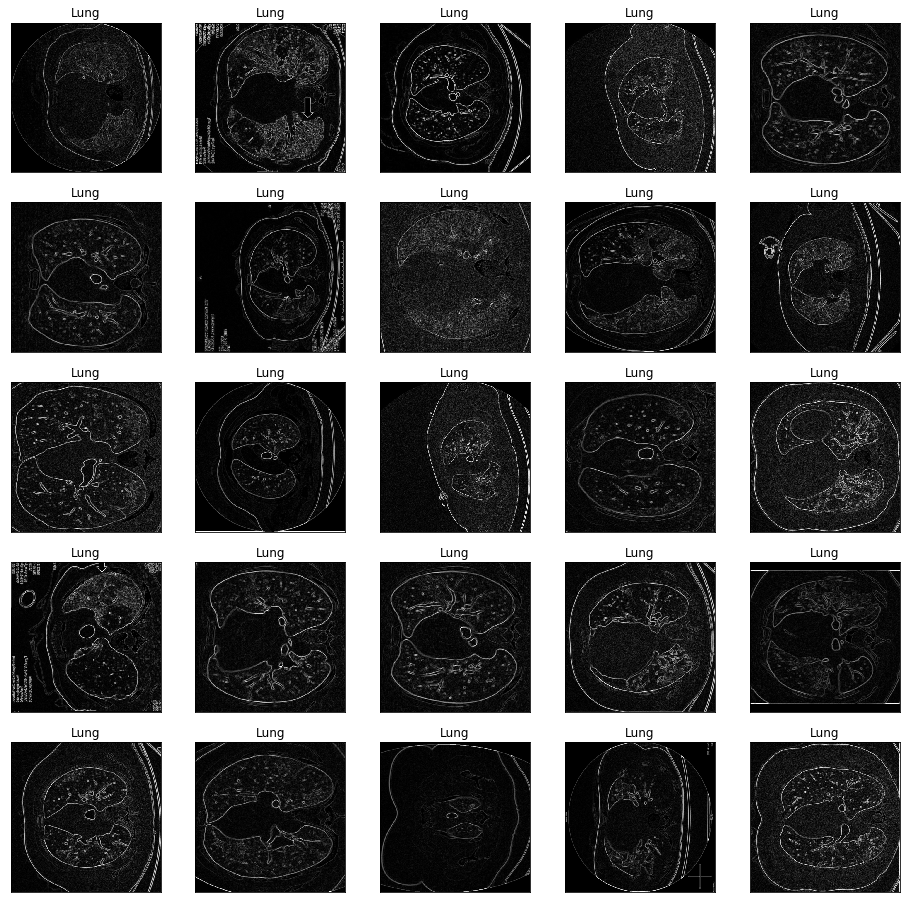

In [78]:
showImages(trainSobel[:25],5,5)
print('First 25 Sobel Gradient from Train Images')
print('######################################')

All Segmented Lungs from Test Images
######################################


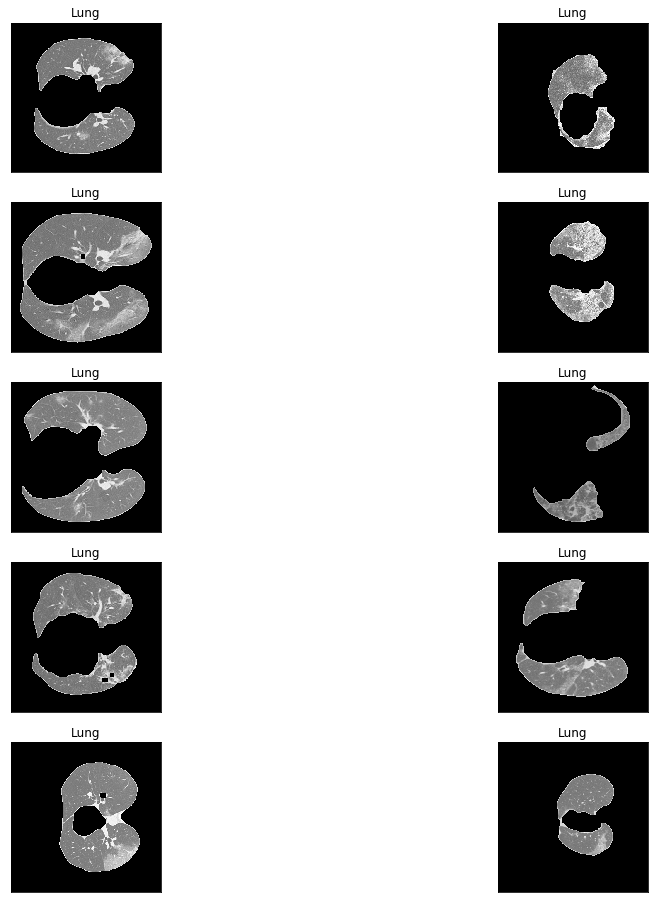

In [79]:
showImages(testSegmentedLungs[:10],5,2)
print('All Segmented Lungs from Test Images')
print('######################################')

All Sobel Gradient from Train Images
######################################


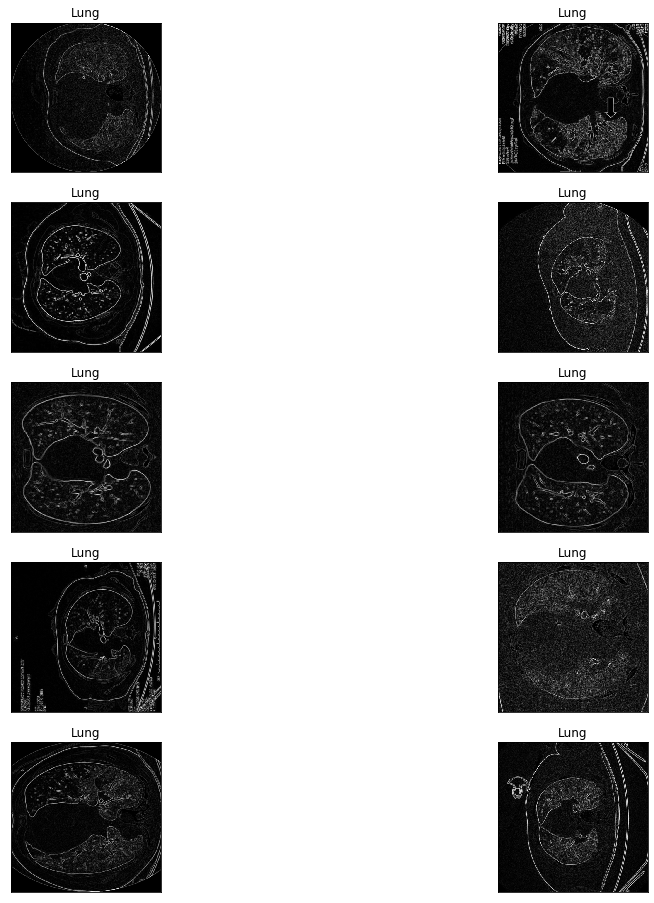

In [80]:
showImages(trainSobel[:10],5,2)
print('All Sobel Gradient from Train Images')
print('######################################')

### End of the adapted code

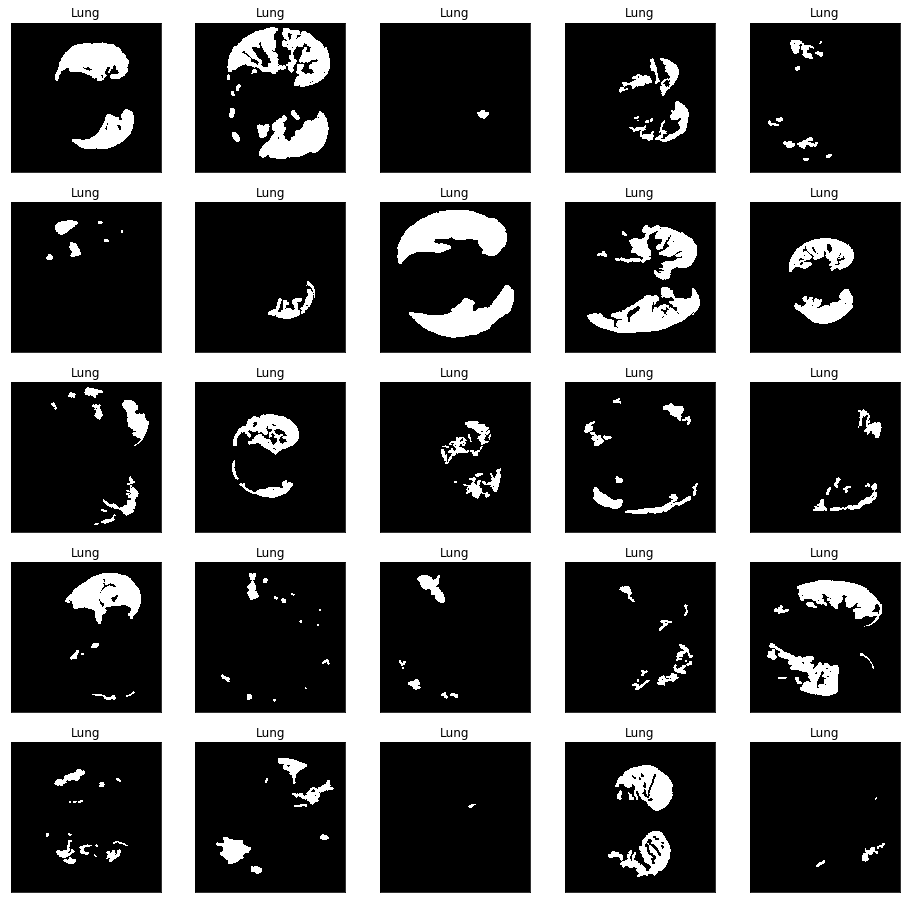

In [96]:
#we can get the values of the "healthy" zones of the lung
#using the segmentations of lungs and the mask.
masks = nib.load('tr_mask.nii.gz')
masks = getImages(masks)
#we consider type 1, type 2 and type 3 as 'sick' parts of the lung
masks[masks==2] = 1
masks[masks==3] = 1
showImages(masks[:25],5,5)

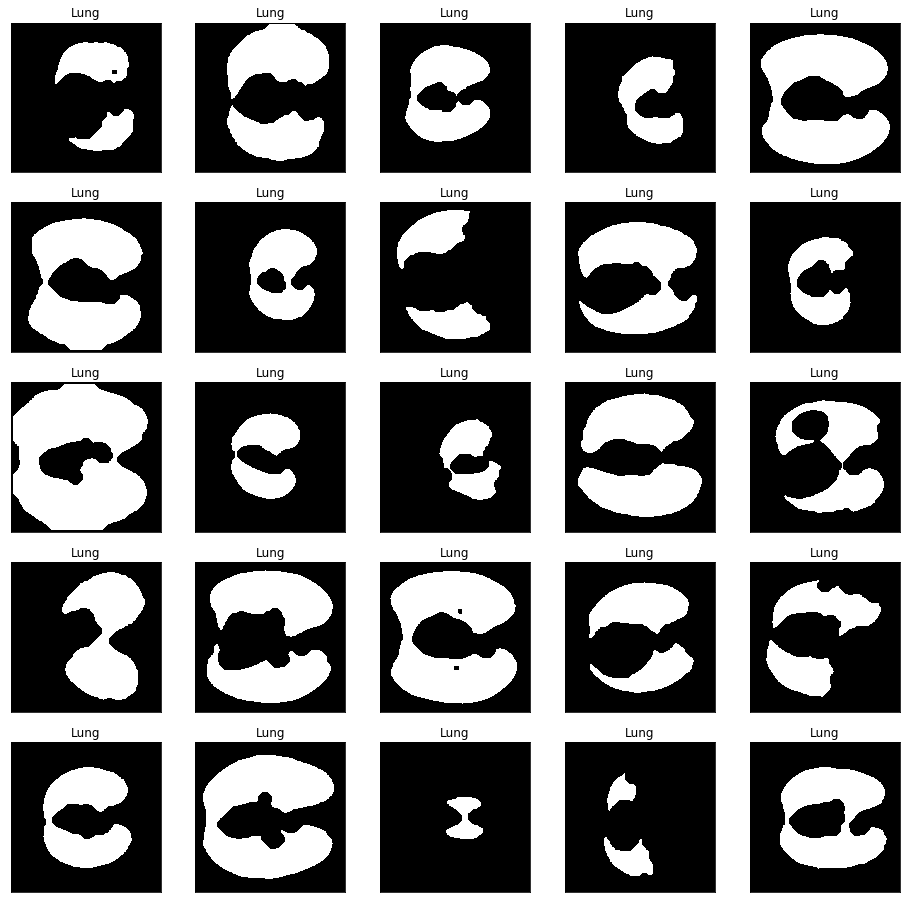

In [94]:
showImages(trainMasks[:25],5,5)

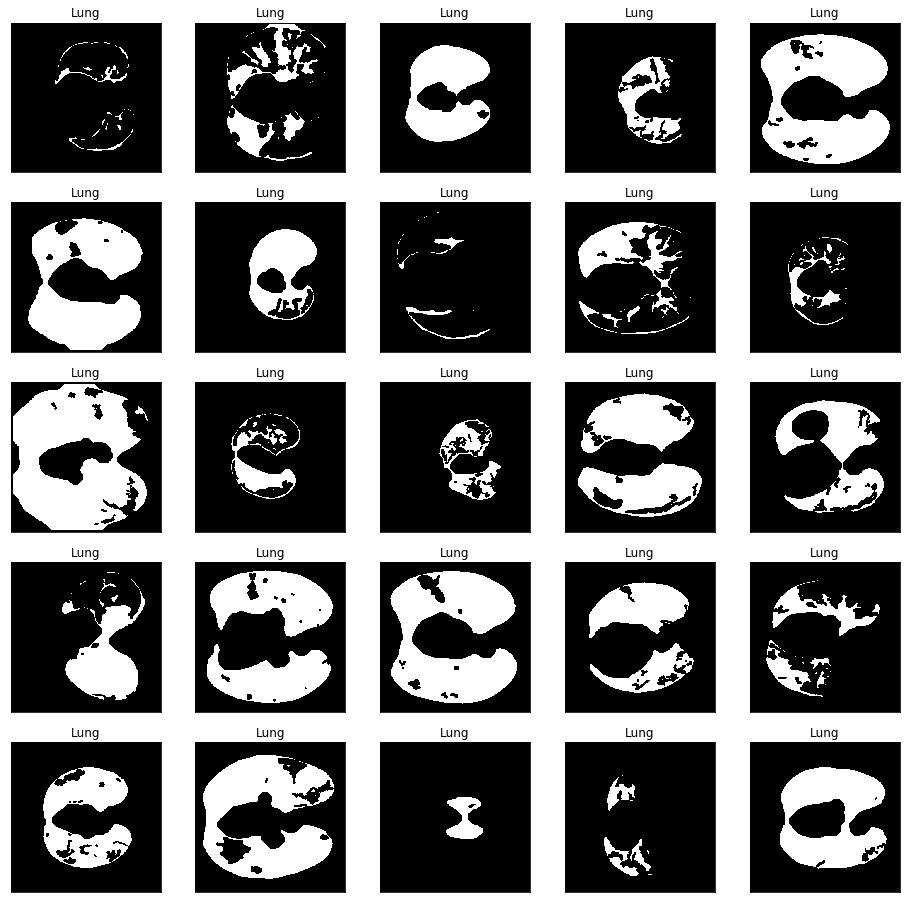

In [97]:
substract = trainMasks - masks
substract[substract==-1] = 0
showImages(substract[:25],5,5)

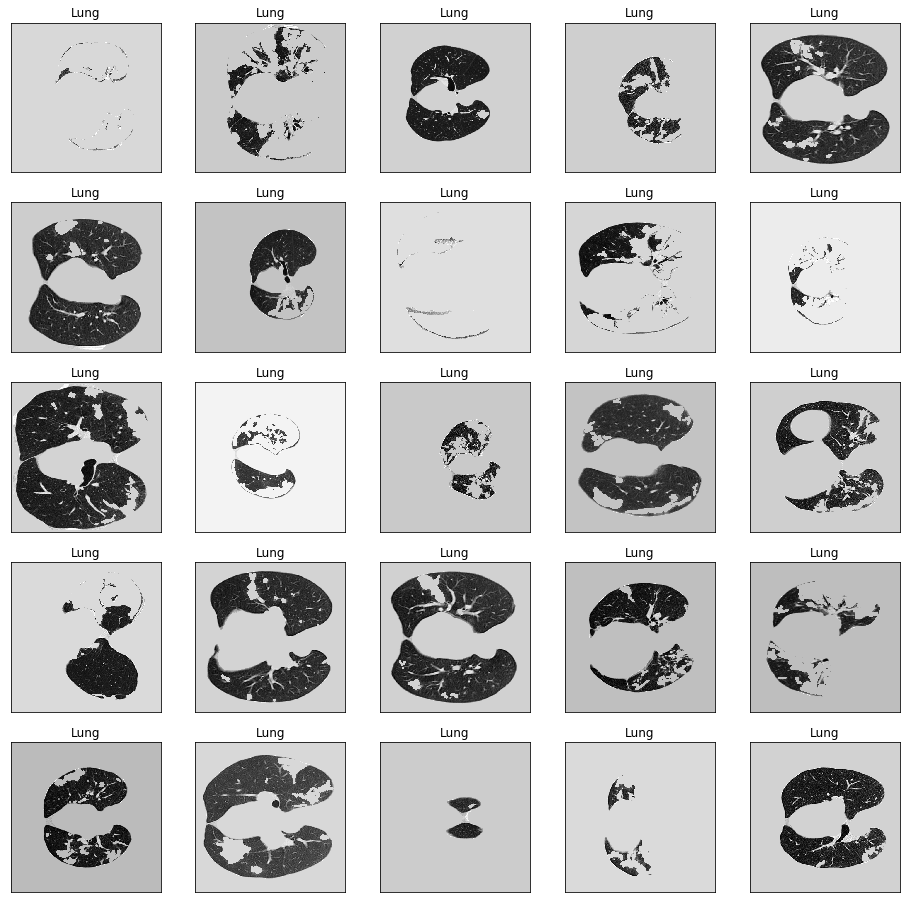

In [98]:
healthy = np.multiply(train,substract)
showImages(healthy[:25],5,5)